In [22]:
%pip install langchain langchain_community tiktoken langchain-nomic "nomic[local]" langchain_ollama scikit-learn langgraph tavily-python bs4 requests selenium PyPDF2 pdfminer.six PyMuPDF sentence-transformers chromadb openai pdfplumber

Note: you may need to restart the kernel to use updated packages.


In [23]:
%pip install langchain-nomic

Note: you may need to restart the kernel to use updated packages.


In [24]:
%pip install httpx langchain httpcore

Note: you may need to restart the kernel to use updated packages.


In [25]:
from langchain_ollama import ChatOllama

local_llm = "llama3.2:3b-instruct-fp16"
llm = ChatOllama(model=local_llm, temperature=0, base_url="http://127.0.0.1:11434")
llm_json_mode = ChatOllama(model=local_llm, temperature=0, format="json", base_url="http://127.0.0.1:11434")

In [26]:
import os
import getpass


def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


_set_env("TAVILY_API_KEY")
os.environ["TOKENIZERS_PARALLELISM"] = "true"

In [27]:
_set_env("LANGSMITH_API_KEY")
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "local-llama32-rag"

In [28]:
from langchain.utilities import RequestsWrapper

# Configura o RequestsWrapper com User-Agent
requests_wrapper = RequestsWrapper(headers={
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/114.0.0.0 Safari/537.36"
})

In [30]:
import os
import fitz
import pdfplumber
import pandas as pd
from langchain.schema import Document
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import SKLearnVectorStore
from langchain_community.document_loaders import WebBaseLoader
from langchain_nomic.embeddings import NomicEmbeddings

# Diretórios
#csv_directory = "./inf_mensal_fii_2024"
pdf_directory = "./pdfs_b3"

# ===== 1. Funções auxiliares =====

def extract_text_from_csv(csv_path):
    try:
        df = pd.read_csv(csv_path, encoding="utf-8", on_bad_lines="skip")
        rows_as_text = df.apply(lambda row: ", ".join(f"{col}: {val}" for col, val in row.items()), axis=1)
        return "\n".join(rows_as_text)
    except Exception as e:
        print(f"[Erro CSV] {csv_path}: {e}")
        return None

def extract_text_from_pdf(pdf_path):
    try:
        with pdfplumber.open(pdf_path) as pdf:
            return "\n".join(page.extract_text() or "" for page in pdf.pages)
    except Exception as e:
        print(f"[Erro PDF] {pdf_path}: {e}")
        return None

# ===== 2. Carregar PDFs como Document =====

pdf_docs = []
for filename in os.listdir(pdf_directory):
    if filename.endswith(".pdf"):
        path = os.path.join(pdf_directory, filename)
        text = extract_text_from_pdf(path)
        if text:
            pdf_docs.append(Document(page_content=text, metadata={"source": filename}))

# ===== 3. Carregar CSVs como Document =====

# csv_docs = []
# for filename in os.listdir(csv_directory):
#     if filename.endswith(".csv"):
#         path = os.path.join(csv_directory, filename)
#         text = extract_text_from_csv(path)
#         if text:
#             csv_docs.append(Document(page_content=text, metadata={"source": filename}))

# ===== 4. Carregar Web scraping como Document =====

urls = [
    "https://www.clubefii.com.br/fundos_imobiliarios_ranking/2024",
    "https://quantumfinance.com.br/fundos-imobiliarios-maiores-retornos-dividendos-2023/",
    "https://conteudos.xpi.com.br/fundos-imobiliarios/top-25-fundos-imobiliarios/",
    "https://www.suno.com.br/noticias/fundos-imobiliarios-fiis-indicados-setembro-2024-jvj/",
    "https://investidor10.com.br/fiis/dividendos/",
    "https://pt.wikipedia.org/wiki/Fundo_de_Investimento_Imobili%C3%A1rio",
    "https://www.fundsexplorer.com.br/funds",
    "https://www.clubefii.com.br/fundo_imobiliario_lista", 
    "https://fiis.com.br/resumo/",
]

web_docs_raw = [WebBaseLoader(url).load() for url in urls]
web_docs = [doc for sublist in web_docs_raw for doc in sublist]

# ===== 5. Juntar tudo =====

#all_docs = pdf_docs + csv_docs + web_docs
all_docs = pdf_docs + web_docs

# ===== 6. Split em chunks =====

text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=1000, chunk_overlap=200
)
doc_chunks = text_splitter.split_documents(all_docs)

# ===== 7. Gerar embeddings =====

vectorstore = SKLearnVectorStore.from_documents(
    documents=doc_chunks,
    embedding=NomicEmbeddings(model="nomic-embed-text-v1.5", inference_mode="local"),
)

# ===== 8. Criar retriever =====

retriever = vectorstore.as_retriever(k=5)
retriever.invoke("agent memory")
# ===== 9. Consulta de exemplo =====
    
# query = "Quais FIIs mais cresceram em número de cotistas nos últimos meses?"
# resultados = retriever.invoke(query)

# print(f"\n🔍 Resultados para: {query}\n")
# for doc in resultados:
#     print(f"Fonte: {doc.metadata.get('source')}")
#     print(doc.page_content[:500])
#     print("-" * 80)


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, def

[Document(metadata={'id': '6e863c19-561a-4673-97c7-0b0856d6fe2a', 'source': 'Mensal_FII_20241202.pdf'}, page_content='www.itaucorretora.com.br\ndos valores mobiliários objeto deste relatório.\n11. As informações relevantes acerca dos modelos proprietários utilizados pelo Itaú Unibanco estão disponíveis na página do Itaú BBA na\n4. O(s) analista(s) de valores mobiliários, seus cônjuges ou companheiros, possuem, direta ou indiretamente, qualquer interesse financeiro em relação ao(s)\nBloomberg.\nemissor(es) dos valores mobiliários analisados neste relatório.\n12. Outras informações regulatórias importantes disponíveis em https://disclosure.cloud.itau.com.br'),
 Document(metadata={'id': '6fb02fb5-9e1c-48e6-b2ad-e4ea8269b183', 'source': 'Relatório Mensal FII - Junho.pdf'}, page_content='www.itaucorretora.com.br\ndos valores mobiliários objeto deste relatório.\n11. As informações relevantes acerca dos modelos proprietários utilizados pelo Itaú Unibanco estão disponíveis na página do Itaú BB

In [34]:
import json
from langchain_core.messages import HumanMessage, SystemMessage
import httpx


# Prompt
router_instructions = """
    Você é especialista em encaminhar uma pergunta de usuário para uma vectorstore ou pesquisa na Web.

    A vectorstore contém documentos relacionados aos fundos de investimentos imobiliários brasileiro.

    Use a vectorstore para perguntas sobre esses tópicos! Para todo o resto, e especialmente para eventos atuais, use a pesquisa na Web.

    Retorna JSON com uma única chave, datasource, que é “websearch” ou “vectorstore”, dependendo da pergunta.
"""

test_vector_store = llm_json_mode.invoke(
            [SystemMessage(content=router_instructions)]
            + [HumanMessage(content="Quais FIIs são mais rentáveis?")]
)

print(
    json.loads(test_vector_store.content),
)

{'datasource': 'vectorstore'}


In [35]:
# Doc grader instructions
doc_grader_instructions = """
    Você é um classificador que avalia a relevância de um documento recuperado para uma pergunta do usuário.

    Se o documento contiver palavra(s)-chave ou significado semântico relacionado à pergunta, classifique-o como relevante.
"""

# Grader prompt
doc_grader_prompt = """
    Aqui está o documento recuperado: \n\n {document} \n\n Aqui está a pergunta do usuário: \n\n {question}.

    Isso avalia cuidadosa e objetivamente se o documento contém pelo menos algumas informações relevantes para a pergunta.

    Retorna JSON com uma única chave, binary_score, que é a pontuação “sim” ou “não” para indicar se o documento contém pelo menos algumas informações relevantes para a pergunta.
"""

# Test
question = "Quais são os Top 10 FIIs com maiores retornos no ano?"
docs = retriever.invoke(question)
doc_txt = docs[1].page_content
doc_grader_prompt_formatted = doc_grader_prompt.format(
    document=doc_txt, question=question
)
result = llm_json_mode.invoke(
    [SystemMessage(content=doc_grader_instructions)]
    + [HumanMessage(content=doc_grader_prompt_formatted)]
)
json.loads(result.content)

Embedding texts: 100%|██████████| 1/1 [00:00<00:00, 21.74inputs/s]


{'binary_score': 'não'}

In [36]:
# Prompt
rag_prompt = """
    Você é um assistente para tarefas de resposta a perguntas.

    Aqui está o contexto a ser usado para responder à pergunta:

    {context}

    Pense cuidadosamente sobre o contexto acima.

    Agora, analise a pergunta do usuário:

    {question}

    Forneça uma resposta a essa pergunta usando somente o contexto acima.

    Use no máximo três frases e mantenha a resposta concisa.

    Responda:
"""


# Post-processing
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)


# Test
docs = retriever.invoke(question)
docs_txt = format_docs(docs)
rag_prompt_formatted = rag_prompt.format(context=docs_txt, question=question)
generation = llm.invoke([HumanMessage(content=rag_prompt_formatted)])
print(generation.content)

Embedding texts: 100%|██████████| 1/1 [00:00<00:00, 16.13inputs/s]


Infelizmente, não há informações sobre os Top 10 FIIs com maiores retornos no ano no contexto fornecido. O texto menciona apenas estratégias de gestão de risco e mudanças na carteira do BCFF, sem fornecer informações sobre os retornos dos Fundos de Investimento Imobiliário (FIIs).


In [37]:
### Hallucination Grader

# Hallucination grader instructions
hallucination_grader_instructions = """

    Você é um professor avaliando um teste.

    Você receberá FATOS e uma RESPOSTA DO ALUNO.

    Aqui estão os critérios de avaliação a serem seguidos:

    (1) Assegure-se de que a RESPOSTA DO ALUNO esteja fundamentada nos FATOS.

    (2) Certifique-se de que a RESPOSTA DO ALUNO não contenha informações “alucinadas” fora do escopo dos FATOS.

    Pontuação:

    Uma pontuação de sim significa que a resposta do aluno atende a todos os critérios. Essa é a pontuação mais alta (melhor).

    Uma pontuação de não significa que a resposta do aluno não atende a todos os critérios. Essa é a menor pontuação possível que você pode dar.

    Explique seu raciocínio passo a passo para garantir que o raciocínio e a conclusão estejam corretos.

    Evite simplesmente declarar a resposta correta no início.
"""

# Grader prompt
hallucination_grader_prompt = """FATOS: \n\n {documents} \n\n RESPOSTA ALUNO: {generation}.

Retorna JSON com duas chaves, binary_score é a pontuação “sim” ou “não” para indicar se a RESPOSTA DO ALUNO está fundamentada nos FATOS. E uma chave, explanation, que contém uma explicação da pontuação."""

# Test using documents and generation from above
hallucination_grader_prompt_formatted = hallucination_grader_prompt.format(
    documents=docs_txt, generation=generation.content
)
result = llm_json_mode.invoke(
    [SystemMessage(content=hallucination_grader_instructions)]
    + [HumanMessage(content=hallucination_grader_prompt_formatted)]
)
json.loads(result.content)

{'binary_score': 'não',
 'explanation': 'A resposta do aluno não está fundamentada nos fatos, pois não há informações sobre os Top 10 FIIs com maiores retornos no ano no contexto fornecido. O texto menciona apenas estratégias de gestão de risco e mudanças na carteira do BCFF, sem fornecer informações sobre os retornos dos Fundos de Investimento Imobiliário (FIIs).'}

In [20]:
# Answer grader instructions
answer_grader_instructions = """
Você é um professor avaliando um teste.

Você receberá uma PERGUNTA e uma RESPOSTA DO ALUNO.

Aqui estão os critérios de avaliação a serem seguidos:

(1) A RESPOSTA DO ALUNO ajuda a responder a PERGUNTA

Pontuação:

Uma pontuação de sim significa que a resposta do aluno atende a todos os critérios. Essa é a pontuação mais alta (melhor).

O aluno pode receber uma pontuação de sim se a resposta contiver informações adicionais que não foram explicitamente solicitadas na pergunta.

Uma pontuação de não significa que a resposta do aluno não atende a todos os critérios. Essa é a pontuação mais baixa possível que você pode dar.

Explique seu raciocínio passo a passo para garantir que o raciocínio e a conclusão estejam corretos.

Evite simplesmente declarar a resposta correta no início."""

# Grader prompt
answer_grader_prompt = """QUESTÃO: \n\n {question} \n\n RESPOSTA ESTUDANTE: {generation}.

Retorna JSON com duas chaves, binary_score é a pontuação “sim” ou “não” para indicar se a RESPOSTA DO ALUNO atende aos critérios. E uma chave, explanation, que contém uma explicação da pontuação."""

# Test
question = "O que são fundos de investimentos imobiliários?"
answer = "FIIs são Fundos Imobiliários, que são investimentos em imóveis ou em empresas que operam com imóveis. Eles podem ser divididos em diferentes segmentos, como logística, recebíveis, lajes comerciais, renda urbana e shopping. Os FIIs oferecem uma forma de investir no mercado imobiliário sem a necessidade de comprar um imóvel físico diretamente."

# Test using question and generation from above
answer_grader_prompt_formatted = answer_grader_prompt.format(
    question=question, generation=answer
)
result = llm_json_mode.invoke(
    [SystemMessage(content=answer_grader_instructions)]
    + [HumanMessage(content=answer_grader_prompt_formatted)]
)
json.loads(result.content)

{'binary_score': 'sim',
 'explanation': 'A resposta do aluno apresenta uma definição clara e precisa de fundos de investimentos imobiliários (FIIs), destacando sua natureza como investimento em imóveis ou empresas que operam com imóveis. Além disso, o aluno menciona os diferentes segmentos em que os FIIs podem ser divididos, o que demonstra uma compreensão mais profunda do assunto. A resposta também destaca a vantagem de investir em FIIs sem a necessidade de comprar um imóvel físico diretamente, o que é uma característica importante dos FIIs. Portanto, a resposta atende aos critérios solicitados e recebe uma pontuação de sim.'}

In [38]:
from langchain_community.tools.tavily_search import TavilySearchResults

web_search_tool = TavilySearchResults(k=5)

In [39]:
import operator
from typing_extensions import TypedDict
from typing import List, Annotated


class GraphState(TypedDict):
    """
    Graph state is a dictionary that contains information we want to propagate to, and modify in, each graph node.
    """

    question: str  # User question
    generation: str  # LLM generation
    web_search: str  # Binary decision to run web search
    max_retries: int  # Max number of retries for answer generation
    answers: int  # Number of answers generated
    loop_step: Annotated[int, operator.add]
    documents: List[str]  # List of retrieved documents

In [40]:
from langchain.schema import Document
from langgraph.graph import END


### Nodes
def retrieve(state):
    """
    Retrieve documents from vectorstore

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    print("---RETRIEVE---")
    question = state["question"]

    # Write retrieved documents to documents key in state
    documents = retriever.invoke(question)
    return {"documents": documents}


def generate(state):
    """
    Generate answer using RAG on retrieved documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """
    print("---GENERATE---")
    question = state["question"]
    documents = state["documents"]
    loop_step = state.get("loop_step", 0)

    # RAG generation
    docs_txt = format_docs(documents)
    rag_prompt_formatted = rag_prompt.format(context=docs_txt, question=question)
    generation = llm.invoke([HumanMessage(content=rag_prompt_formatted)])
    return {"generation": generation, "loop_step": loop_step + 1}


def grade_documents(state):
    """
    Determines whether the retrieved documents are relevant to the question
    If any document is not relevant, we will set a flag to run web search

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Filtered out irrelevant documents and updated web_search state
    """

    print("---CHECK DOCUMENT RELEVANCE TO QUESTION---")
    question = state["question"]
    documents = state["documents"]

    # Score each doc
    filtered_docs = []
    web_search = "No"
    for d in documents:
        doc_grader_prompt_formatted = doc_grader_prompt.format(
            document=d.page_content, question=question
        )
        result = llm_json_mode.invoke(
            [SystemMessage(content=doc_grader_instructions)]
            + [HumanMessage(content=doc_grader_prompt_formatted)]
        )
        grade = json.loads(result.content)["binary_score"]
        # Document relevant
        if grade.lower() == "yes":
            print("---GRADE: DOCUMENT RELEVANT---")
            filtered_docs.append(d)
        # Document not relevant
        else:
            print("---GRADE: DOCUMENT NOT RELEVANT---")
            # We do not include the document in filtered_docs
            # We set a flag to indicate that we want to run web search
            web_search = "Yes"
            continue
    return {"documents": filtered_docs, "web_search": web_search}


def web_search(state):
    """
    Web search based based on the question

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Appended web results to documents
    """

    print("---WEB SEARCH---")
    question = state["question"]
    documents = state.get("documents", [])

    # Web search
    docs = web_search_tool.invoke({"query": question})
    web_results = "\n".join([d["content"] for d in docs])
    web_results = Document(page_content=web_results)
    documents.append(web_results)
    return {"documents": documents}


### Edges


def route_question(state):
    """
    Route question to web search or RAG

    Args:
        state (dict): The current graph state

    Returns:
        str: Next node to call
    """

    print("---ROUTE QUESTION---")
    route_question = llm_json_mode.invoke(
        [SystemMessage(content=router_instructions)]
        + [HumanMessage(content=state["question"])]
    )
    source = json.loads(route_question.content)["datasource"]
    if source == "websearch":
        print("---ROUTE QUESTION TO WEB SEARCH---")
        return "websearch"
    elif source == "vectorstore":
        print("---ROUTE QUESTION TO RAG---")
        return "vectorstore"


def decide_to_generate(state):
    """
    Determines whether to generate an answer, or add web search

    Args:
        state (dict): The current graph state

    Returns:
        str: Binary decision for next node to call
    """

    print("---ASSESS GRADED DOCUMENTS---")
    question = state["question"]
    web_search = state["web_search"]
    filtered_documents = state["documents"]

    if web_search == "Yes":
        # All documents have been filtered check_relevance
        # We will re-generate a new query
        print(
            "---DECISION: NOT ALL DOCUMENTS ARE RELEVANT TO QUESTION, INCLUDE WEB SEARCH---"
        )
        return "websearch"
    else:
        # We have relevant documents, so generate answer
        print("---DECISION: GENERATE---")
        return "generate"


def grade_generation_v_documents_and_question(state):
    """
    Determines whether the generation is grounded in the document and answers question

    Args:
        state (dict): The current graph state

    Returns:
        str: Decision for next node to call
    """

    print("---CHECK HALLUCINATIONS---")
    question = state["question"]
    documents = state["documents"]
    generation = state["generation"]
    max_retries = state.get("max_retries", 3)  # Default to 3 if not provided

    hallucination_grader_prompt_formatted = hallucination_grader_prompt.format(
        documents=format_docs(documents), generation=generation.content
    )
    result = llm_json_mode.invoke(
        [SystemMessage(content=hallucination_grader_instructions)]
        + [HumanMessage(content=hallucination_grader_prompt_formatted)]
    )
    grade = json.loads(result.content)["binary_score"]

    # Check hallucination
    if grade == "yes":
        print("---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---")
        # Check question-answering
        print("---GRADE GENERATION vs QUESTION---")
        # Test using question and generation from above
        answer_grader_prompt_formatted = answer_grader_prompt.format(
            question=question, generation=generation.content
        )
        result = llm_json_mode.invoke(
            [SystemMessage(content=answer_grader_instructions)]
            + [HumanMessage(content=answer_grader_prompt_formatted)]
        )
        grade = json.loads(result.content)["binary_score"]
        if grade == "yes":
            print("---DECISION: GENERATION ADDRESSES QUESTION---")
            return "useful"
        elif state["loop_step"] <= max_retries:
            print("---DECISION: GENERATION DOES NOT ADDRESS QUESTION---")
            return "not useful"
        else:
            print("---DECISION: MAX RETRIES REACHED---")
            return "max retries"
    elif state["loop_step"] <= max_retries:
        print("---DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY---")
        return "not supported"
    else:
        print("---DECISION: MAX RETRIES REACHED---")
        return "max retries"

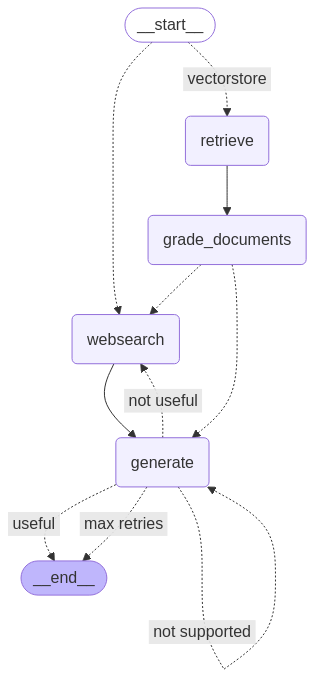

In [41]:
from langgraph.graph import StateGraph
from IPython.display import Image, display

workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("websearch", web_search)  # web search
workflow.add_node("retrieve", retrieve)  # retrieve
workflow.add_node("grade_documents", grade_documents)  # grade documents
workflow.add_node("generate", generate)  # generate

# Build graph
workflow.set_conditional_entry_point(
    route_question,
    {
        "websearch": "websearch",
        "vectorstore": "retrieve",
    },
)
workflow.add_edge("websearch", "generate")
workflow.add_edge("retrieve", "grade_documents")
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "websearch": "websearch",
        "generate": "generate",
    },
)
workflow.add_conditional_edges(
    "generate",
    grade_generation_v_documents_and_question,
    {
        "not supported": "generate",
        "useful": END,
        "not useful": "websearch",
        "max retries": END,
    },
)

# Compile
graph = workflow.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

In [42]:
inputs = {"question": "Quais os melhores FIIs a se investir?", "max_retries":5};
for event in graph.stream(inputs, stream_mode="values"):
    print(event)

---ROUTE QUESTION---
---ROUTE QUESTION TO RAG---
{'question': 'Quais os melhores FIIs a se investir?', 'max_retries': 5, 'loop_step': 0}
---RETRIEVE---


Embedding texts: 100%|██████████| 1/1 [00:00<00:00, 21.74inputs/s]

{'question': 'Quais os melhores FIIs a se investir?', 'max_retries': 5, 'loop_step': 0, 'documents': [Document(metadata={'id': '15116f52-431f-4cee-9480-0c4e1559815b', 'source': 'https://quantumfinance.com.br/fundos-imobiliarios-maiores-retornos-dividendos-2023/', 'title': 'Fundos Imobiliários: veja os maiores retornos e dividendos de 2025', 'description': 'O estudo apontou os 10 melhores fundos imobiliários em retorno no acumulado do ano de 2025, assim como os melhores FIIs em dividend yield.', 'language': 'pt-br'}, page_content='Fundos Imobiliários: veja os maiores retornos e dividendos de 2025\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n \n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n   \n\n\n\n\n\n\nQuem SomosCarreirasLaboratório Quantum PUC IAConselho ConsultivoSoluçõesQuantum AxisQuantum PortfólioQuantum PrevQuantum InvestConsolidação de CarteirasQuantum White LabelSoluções de integraçãoComparador de ativosBasesClientesCo

---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: NOT ALL DOCUMENTS ARE RELEVANT TO QUESTION, INCLUDE WEB SEARCH---
{'question': 'Quais os melhores FIIs a se investir?', 'web_search': 'Yes', 'max_retries': 5, 'loop_step': 0, 'documents': []}
---WEB SEARCH---
{'question': 'Quais os melhores FIIs a se investir?', 'web_search': 'Yes', 'max_retries': 5, 'loop_step': 0, 'documents': [Document(metadata={}, page_content='O BTG começa destacando que, para este ano, a reforma tributária e a viabilidade política do pacote econômico proposto pelo governo serão pontos-chave, enquanto a independência do Banco Central enfrentará testes em um ambiente de inflação projetada de 5,5% e crescimento econômico de 1,6%.\n\nDiante disso, os melhores FIIs para investir em 2025, segundo o BTG, são os seguintes:\n\nKinea Rendimentos Imobiliários (KNCR11) [...] Siga o Suno Notícias